# Imports

In [1]:
using Distributed
using MAT
using Plots
using Images

include("./unmixing_optimization/main.jl");

# Data Visualization

In [2]:
pyplot()
filename = "../project_data.mat"
file = matopen(filename)
img = read(file, "im")
sources = read(file,"sources")
rgb = read(file,"rgb")
close(file);

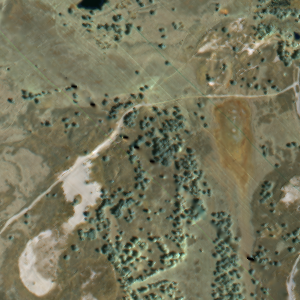

In [3]:
# Visualize data in rgb (using bands 67,109,141 as th RGB channels)
p1 = colorview(RGB, permutedims(rgb,(3,1,2))) # convert 3d array to the image format used by julia

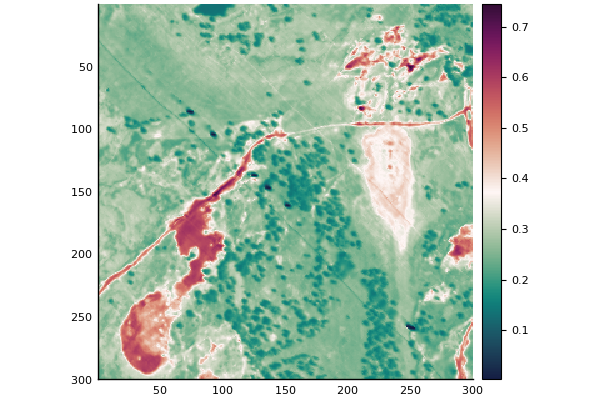

In [4]:
# Visualize a spectral band on its own
p2 = heatmap(img[:,:,150],aspect_ratio=1, yflip = true, c=:curl)

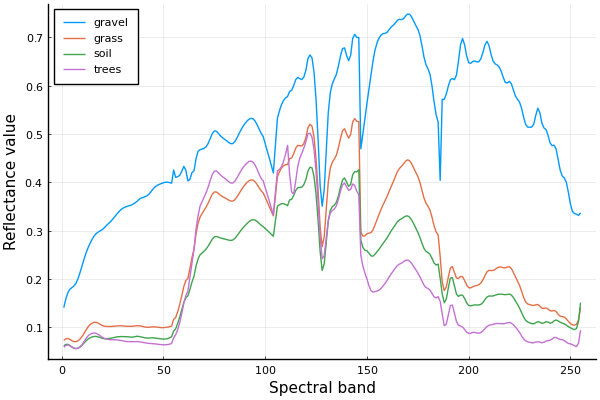

In [5]:
# visualize the endmembers to be used

plot(sources[:,1],label = "gravel")
plot!(sources[:,2],label = "grass")
plot!(sources[:,3],label = "soil")
plot!(sources[:,4],label = "trees")
xlabel!("Spectral band")
ylabel!("Reflectance value")

## Unmixing the image

The model we are using to decompose the image into the sum of the contributions of the endmembers is:

\begin{equation*}
\mathbf{X} = \mathbf{S}\mathbf{A} + \mathbf{E} 
\end{equation*}

 $\mathbf{X}\in \mathbb{R}^{L\times N}$ : data matrix
 
 $\mathbf{S}\in \mathbb{R}^{L\times P}$ : endmember matrix
 
 $\mathbf{A}\in \mathbb{R}^{P\times N}$ : abundance matrix
 
 $\mathbf{E}\in \mathbb{R}^{L\times N}$ : additive noise matrix
 
 where $L$ is the number of spectral bands, $P$ is the number of materials, and $N$ is the number of pixels
 
 The hyperspectral image is represented as a matrix with $N$ pixels, so the first thing to do is to reshape the image to a big matrix.

We can try and estimate the abundance matrix using a least squares formulation:

\begin{equation*}
\hat{A} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2}||\mathbf{X}-\mathbf{SA}||_{F}^{2} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2} \sum_{i=1}^{N} ||\mathbf{x}_{n}-\mathbf{S}\mathbf{a}_{n}||_{2}^{2}
\end{equation*}

where $\mathbf{1}_{.}$ is a vector of ones whose size is given in index 

Choose an algorithm to solve the optimization problem, and implement it both in a serial version and a version parallelized across the pixels.

In [106]:
n_runtimes = 10

n = 75^2
p = 4
l = 255
k = floor(Int, sqrt(n))

# Use a small crop of the image first
offset_x = 150
offset_y = 1
img_small = img[offset_x:offset_x + k - 1,offset_y:offset_y + k - 1, :]

X = img_small
S = sources;

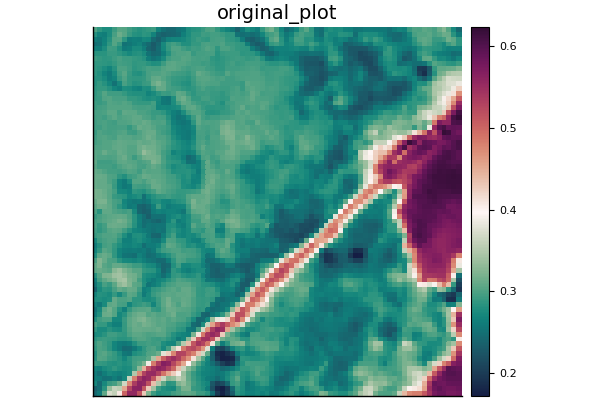

In [107]:
original_plot = heatmap(
    X[:, :, 150], title="original_plot", aspect_ratio=1, yflip = true, c=:curl, grid=false, ticks=false
)

In this project, we used 3 different approaches:

- **Serial pixel-based**: solve the problem for each pixel (ie: `for` loop over pixels of the image);
    - Projected gradient equality constraint;
    - Projected gradient two constraints;
    - Log-barrier;
<br><br>
- **Serial image-based**: solve the problem for whole image (ie: only "one" matrix operation);
    - Interior point least-square;
    - Interior point primal-dual;
<br><br>    
- **Parallel pixel-based**: solve the problem for each pixel with different processors at the same time (ie: parallelized `for` loop over pixels of the image);
    - Log-barrier;

# Serial Projected Gradient (pixel based single constraint)

The main idea here is to **update the current point** $y^{(k)}$ at each iteration $k$ with **its projection** $x^{(k)}$ in the constraint space $\chi$ (cf reference [2]). 

$$ y^{(k+1)} = x^{(k)} - t^{(k)} \Delta x^{(k)}, \space \text{where} \space  x^{(k)} = \text{proj}_\chi(y^{k})$$

This method is **the most simple used in this project**: we only care about the **equality constraint** of the problem. <br>
Indeed, with the equality constraint the pixel-based problem is:

$$
   \begin{cases}
      \mbox{minimize} \space f_0(a) = \Vert x - Sa \Vert_2^2 \\
      \mbox{subject to } \mathbf{1}_{P}^{T} a = 1 
   \end{cases}
$$

where $a$ and $x$ are respectively the abundance vector related one pixel and one pixel of the image.

This problem is **easy to solve**: 

$$p^* = a - \frac{a^T . \mathbf{1}_{P} - 1}{P}\mathbf{1}_{P}$$

In [14]:
new_X_1c, A_1c, mean_loss_1c = estimate_abundance(X, S, "projected_gradient_1c", "serial_pixel");

In [22]:
println("Check the equality constraint on a random pixel: ", rand(sum(A_1c, dims=3)))
println("Check the inequality constraint: ", all(x -> x >= 0, A_1c))

Check the equality constraint on a random pixel: 1.0132328199899359
Check the inequality constraint: false


In [23]:
n_pixels, time_1c = get_runtime_series(X, S, "projected_gradient_1c", "serial_pixel", n_runtimes);

In [24]:
pg_1c_plot = heatmap(
    new_X_1c[:, :, 150], title="projected_gradient_1c", 
    aspect_ratio=1, yflip = true, c=:curl, grid=false, ticks=false, size=(1000, 400)
);
pg_1c_loss = plot(
    log.(mean_loss_1c[mean_loss_1c .> 0]),
    title="Evolution of the log of pixel-mean loss for each iteration",
    ylabel = "Log pixel-mean loss", 
    xlabel = "Number of iteration", 
    label="projected_gradient_1c",
    color="#377eb8"
    
);

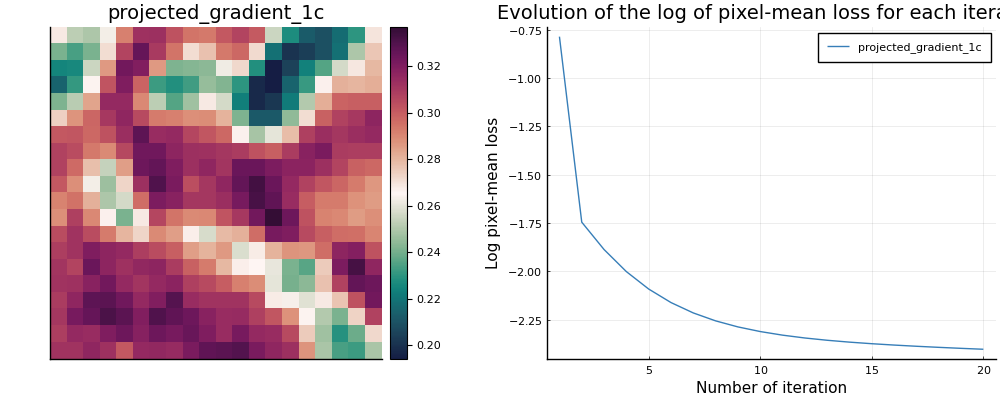

In [25]:
plot(pg_1c_plot, pg_1c_loss, layout=(1, 2), size=(1000, 400))

This method is **very effective**, converges with a **high precision** but it takes only one constraint into account, which is **a drawback**. 

# Serial Projected Gradient (pixel based and two constraints)

Add method description ...

In [26]:
new_X_2c, A_2c, mean_loss_2c = estimate_abundance(X, S, "projected_gradient_2c", "serial_pixel");

In [27]:
println("Check the equality constraint on a random pixel: ", rand(sum(A_2c, dims=3)))
println("Check the inequality constraint: ", all(x -> x >= 0, A_2c))

Check the equality constraint on a random pixel: 0.9999999999999999
Check the inequality constraint: true


In [56]:
n_pixels, time_2c = get_runtime_series(X, S, "projected_gradient_2c", "serial_pixel", n_runtimes);

In [31]:
pg_2c_plot = heatmap(
    new_X_2c[:, :, 150], title="projected_gradient_2c", 
    aspect_ratio=1, yflip = true, c=:curl, grid=false, ticks=false, size=(1000, 400)
);
pg_2c_loss = plot(
    log.(mean_loss_2c[mean_loss_2c .> 0]),
    title="Evolution of the log of pixel-mean loss for each iteration",
    ylabel = "Log pixel-mean loss", 
    xlabel = "Number of iteration", 
    label="projected_gradient_2c",
    color="#e41a1c"
);

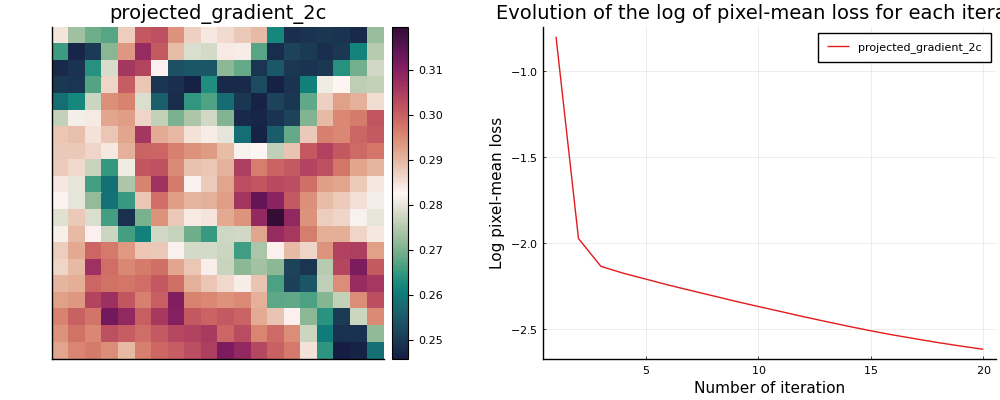

In [32]:
plot(pg_2c_plot, pg_2c_loss, layout=(1, 2), size=(1000, 400))

Add comments ...

# Serial Log-barrier (pixel based)

The Log Barrier method is a penalty method.

The problem : $$\mbox{minimize} f(x) \space s.t \space g(x)<=0, Ax=b \space is \space replaced \space by : 
$$
$$
   \begin{cases}
              \mbox{minimize} \space t*f(x) \space + \space  \Phi(x)  \space , with \space \begin{equation*}
\Phi(x) = \sum_{i} \mathbf log(-{g}_{i}(x))
\end{equation*} \\
\mbox{subject to } \mathbf{A}x = b
   \end{cases}
$$

In [110]:
new_X_lb, A_lb, mean_loss_lb = estimate_abundance(X, S, "log_barrier", "serial_pixel");

In [111]:
println("Check the equality constraint on a random pixel: ", rand(sum(A_lb, dims=3)))
println("Check the inequality constraint: ", all(x -> x >= 0, A_lb))

Check the equality constraint on a random pixel: 1.0000000000000002
Check the inequality constraint: true


In [112]:
n_pixels, time_lb = get_runtime_series(X, S, "log_barrier", "serial_pixel", n_runtimes);

In [113]:
lb_plot = heatmap(
    new_X_lb[:, :, 150], title="log_barrier", 
    aspect_ratio=1, yflip = true,c=:curl, grid=false, ticks=false, size=(1000, 400)
);
lb_loss = plot(
    log.(mean_loss_lb[mean_loss_lb .> 0]),
    title="Evolution of the log of pixel-mean loss for each iteration",
    ylabel = "Log pixel-mean loss", 
    xlabel = "Number of iteration",
    label="log_barrier",
    color="#4daf4a"
);

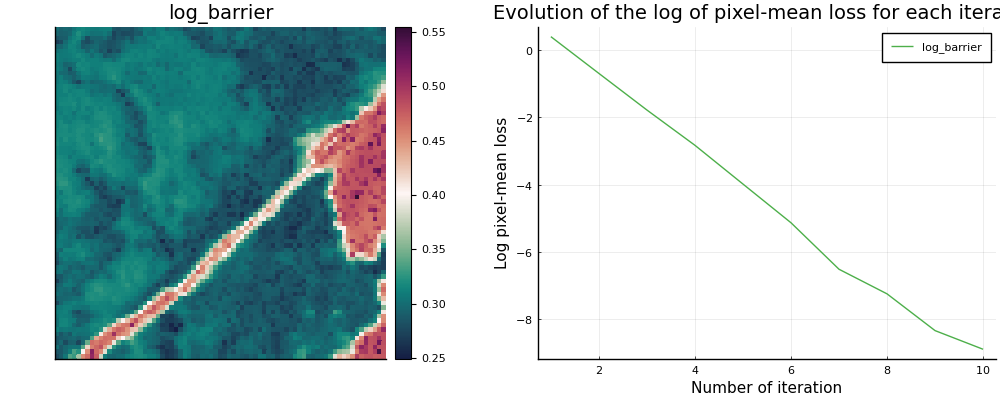

In [114]:
plot(lb_plot, lb_loss, layout=(1, 2), size=(1000, 400))

This log barrier method is **very effective**.
It converges to a log pixel-mean loss loss that is lower than the one using other methods such as the projected gradient.
More over the log barrier-method **converges quickly**.
We can observe that the image is **well reconstituted**.

# Serial Interior Point Least Square (image-based)

We consider here the case of an image based approach where the unmixing will be done on **the complete image without iterating on pixels**. To do so, we mainly used primal-dual interior point techniques discussed in the following paper [1].

Also, the **algorithm is vectorized** in a way that for an $(n,p)$ matrix, we consider the associated reshaped vector constituted of $n \space x \space p$  lines.

Moreover, to **ensure the equality constraint**, we made a **reparametrization of our problem**:

$$
   \begin{cases}
      \mbox{minimize}_{U \in \mathbb{R}^{(P-1) x N}} \space f_0(A_0 + ZU) = \Vert X - S(A_0 + ZU) \Vert_F^2 \\
      \mbox{subject to } A_0 + ZU \geq 0 
   \end{cases}
$$

where $A_0 \in \mathbb{R}^{P x N}$, $Z \in \mathbb{R}^{P x (P-1)}$ and $Z \in \text{ker}(\mathbf{1}_{P}^{T}) $ (for more details check out [1]).

The algorithm estimates at the same time the **abundance matrix** and the **Lagrange multipliers**. The corresponding directions are found using **Newton algorithm**. At each iteration, the respect of the constraint is ensured by adding a **logarithmic barrier function** making the criterion unbounded at the boundary of the feasible solution domain.

A **backtracking** using line search with Armijo condition is applied to find the **optimal stepsize** at each descent. 

Finally, and in order to ensure convergence, we ensure that KKT conditions are fulfilled at each step by **updating the perturbations**.

In [30]:
new_X_ipls, A_ipls, loss_ipls = estimate_abundance(X, S, "ipls", "serial_image");

In [33]:
println("Check the equality constraint on a random pixel: ", rand(sum(A_ipls, dims=3)))
println("Check the inequality constraint: ", all(x -> x >= 0, A_ipls))

Check the equality constraint on a random pixel: 1.0000000000000002
Check the inequality constraint: true


In [70]:
n_pixels, time_ipls = get_runtime_series(X, S, "ipls", "serial_image", n_runtimes);

In [43]:
ipls_plot = heatmap(
    new_X_ipls[:, :, 150], title="ipls", 
    aspect_ratio=1, yflip = true,c=:curl, grid=false, ticks=false, size=(1000, 400)
);
ipls_loss = plot(
    log.(loss_ipls[loss_ipls .> 0]),
    title="Evolution of the log of pixel-mean loss for each iteration",
    ylabel = "Log pixel-mean loss", 
    xlabel = "Number of iteration",
    label="ipls",
    color="#984ea3"
);

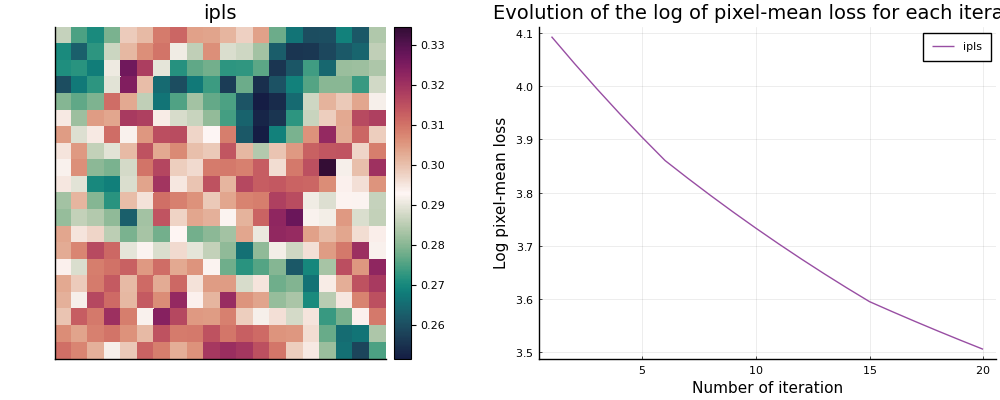

In [35]:
plot(ipls_plot, ipls_loss, layout=(1, 2), size=(1000, 400))

Results show **low performances** in terms of image reconstitution however, the plot above shows a decreasing loss at each time step: it **converges**.

# Serial Interior Point Primal-Dual (image-based)

In this section, we have implemented the interior point primal-dual algorithm described in [3].

It's the **global same idea as the previous method** - interior point least square -, however, here we **don't reparametrize the problem** and the **inequality constraint is ensured in the backtracking**. Morever, stopping criteria are note the same: **there is no logarithmic barrier**.

In [44]:
new_X_primaldual, A_primaldual, loss_primaldual = estimate_abundance(X, S, "primal_dual", "serial_image");

In [45]:
println("Check the equality constraint on a random pixel: ", rand(sum(A_primaldual, dims=3)))
println("Check the inequality constraint: ", all(x -> x >= 0, A_primaldual))

Check the equality constraint on a random pixel: 0.27388338712139315
Check the inequality constraint: true


In [67]:
n_pixels, time_primaldual = get_runtime_series(X, S, "primal_dual", "serial_image", n_runtimes);

In [46]:
primaldual_plot = heatmap(
    new_X_primaldual[:, :, 150], title="primal_dual", 
    aspect_ratio=1, yflip = true,c=:curl, grid=false, ticks=false, size=(1000, 400)
);
primaldual_loss = plot(
    log.(loss_primaldual[loss_primaldual .> 0]),
    title="Evolution of the log of pixel-mean loss for each iteration",
    ylabel = "Log pixel-mean loss", 
    xlabel = "Number of iteration",
    label="primal_dual",
    color="#ff7f00"
);

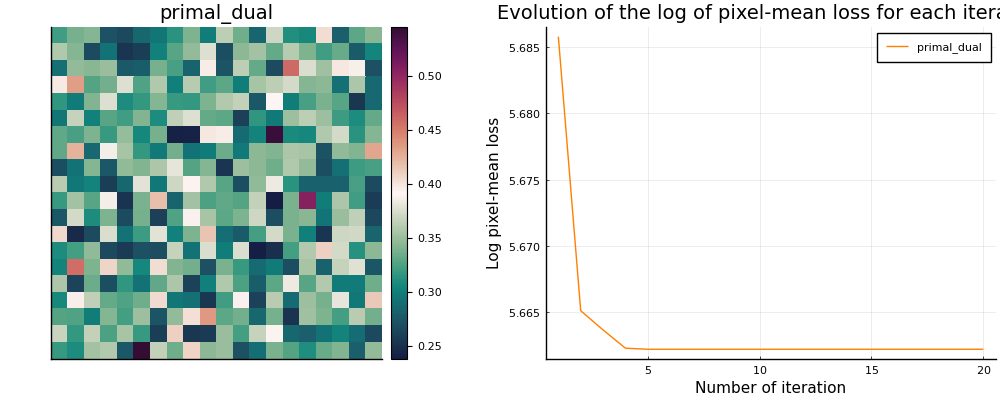

In [47]:
plot(primaldual_plot, primaldual_loss, layout=(1, 2), size=(1000, 400))

This method is **not very precise**, it **converges** but to a **high loss** ...

We believe that with more time we could have **fine-tuned its parameters** and succeeded to obtain better results.

# Parallel Log-barrier (pixel based)

## Description: 
Parallel implementation of the log-barrier algorithm.
The parallelisation is made over the column of the matrix X.

In [115]:
time_series_parallel = Dict()
X_parallel_lb = Dict()
for i=1:3
    addprocs(i)
    @everywhere include("./unmixing_optimization/main.jl")
    n_pixels, time_series_parallel[i+1] = get_runtime_series(X, S, "log_barrier","parallel_pixel",n_runtimes)
    X_parallel_lb[i+1], _, _ = estimate_abundance(X, S, "log_barrier", "parallel_pixel");
end;

In [116]:
parallel_lb_4_plot = heatmap(
    X_parallel_lb[4][:, :, 150], title="parallel_4_log_barrier", 
    aspect_ratio=1, yflip = true, c=:curl, grid=false, ticks=false
);

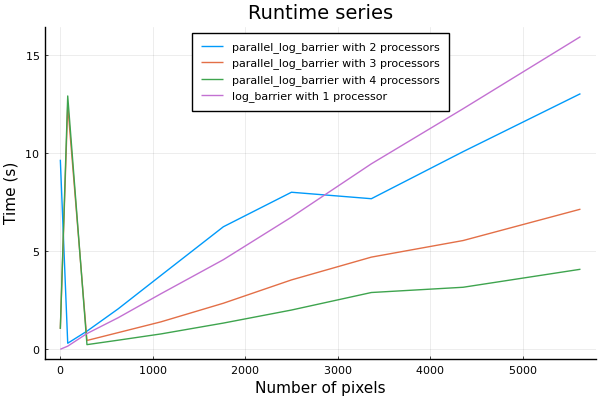

In [117]:
n_pixels2 = [n_pixels[i]^2 for i=1:length(n_pixels)]

plot()

for i=1:length(time_series_parallel)
    plot!(
        n_pixels2,time_series_parallel[i+1],
        title="Runtime series",
        ylabel = "Time (s)", 
        xlabel = "Number of pixels", 
        label=string("parallel_log_barrier with ",string(i+1)," processors")
    )
end


plot!(n_pixels2, time_lb,
    label="log_barrier with 1 processor",
    ylabel = "Time (s)", 
    xlabel = "Number of pixels", 
)

In [109]:
rmprocs(procs()[2:end])

Task (done) @0x000000001447d9f0

We can see that the more processor we use, the more quickly the algorithm converges.
What we could try to do to improve the parallelization is to paralelize the algorithm on each pixel rather than on each column. 

# Model Comparison

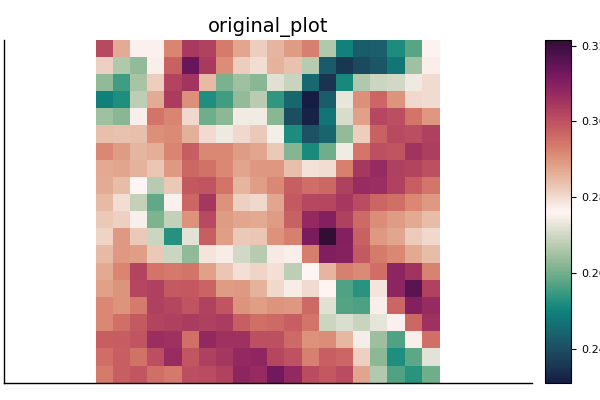

In [62]:
plot(original_plot)

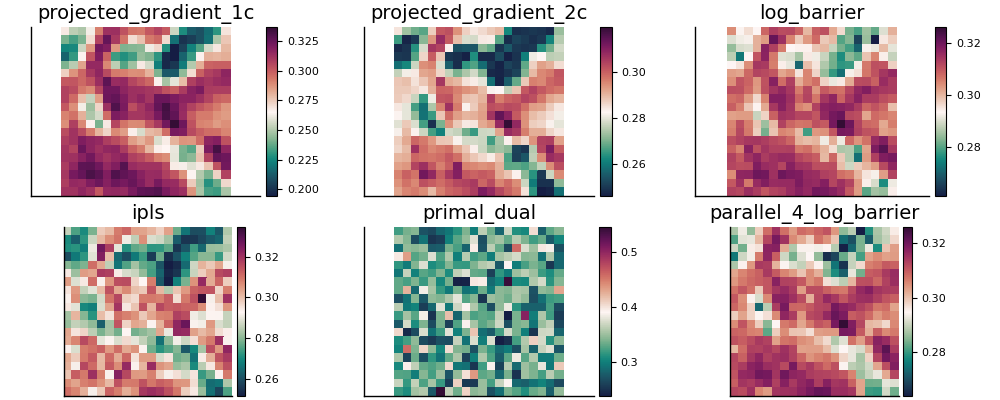

In [63]:
p = plot(
    pg_1c_plot, pg_2c_plot, lb_plot, ipls_plot, primaldual_plot, parallel_lb_4_plot, 
    layout=(2, 3), size=(1000, 400)
)

Add comments ...

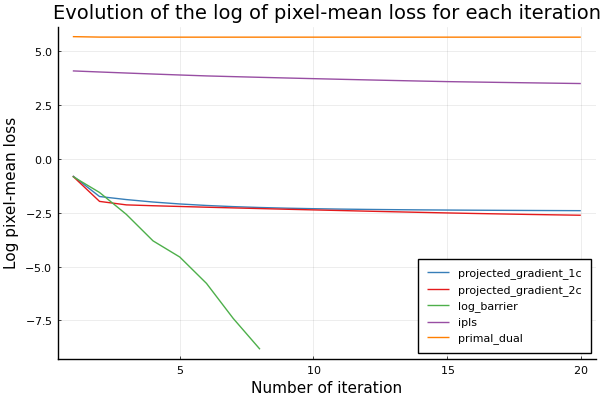

In [64]:
plot(
    log.(mean_loss_1c[mean_loss_1c .> 0]),
    title="Evolution of the log of pixel-mean loss for each iteration",
    ylabel = "Log pixel-mean loss", 
    xlabel = "Number of iteration", 
    label="projected_gradient_1c",
    color="#377eb8"
    
)
plot!(
    log.(mean_loss_2c[mean_loss_2c .> 0]),
    label="projected_gradient_2c",
    color="#e41a1c"
)
plot!(
    log.(mean_loss_lb[mean_loss_lb .> 0]),
    label="log_barrier",
    color="#4daf4a"
)
plot!(
    log.(loss_ipls[loss_ipls .> 0]),
    label="ipls",
    color="#984ea3"
)
plot!(
    log.(loss_primaldual[loss_primaldual .> 0]),
    label="primal_dual",
    color="#ff7f00"
)

Add comments ...

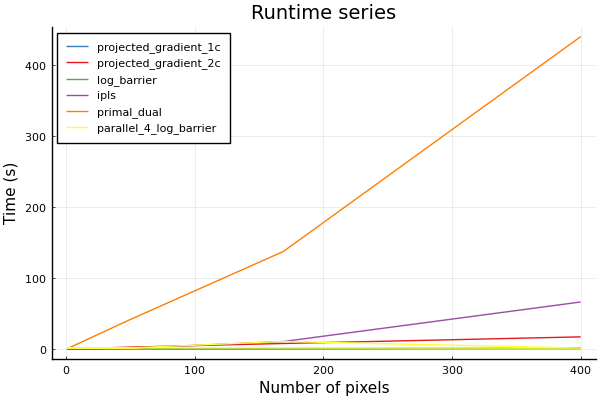

In [71]:
n_pixels2 = [k^2 for k = n_pixels]
plot(
    n_pixels2, time_1c,
    title="Runtime series",
    ylabel = "Time (s)", 
    xlabel = "Number of pixels", 
    label="projected_gradient_1c",
    color="#377eb8"
    
)
plot!(
    n_pixels2, time_2c,
    label="projected_gradient_2c",
    color="#e41a1c"
)
plot!(
    n_pixels2, time_lb,
    label="log_barrier",
    color="#4daf4a"
)
plot!(
    n_pixels2, time_ipls,
    label="ipls",
    color="#984ea3"
)
plot!(
    n_pixels2, time_primaldual,
    label="primal_dual",
    color="#ff7f00"
)
plot!(
    n_pixels2, time_series_parallel[4],
    label="parallel_4_log_barrier",
    color="#ffff33"
)

Add comments ...

# References

[1] "Fast constrained least squares spectral unmixing using
primal-dual interior point optimization", E. Chouzenoux, M. Legendre, S. Moussaoui, J. Idier, https://hal.archives-ouvertes.fr/hal-00828013/document <br><br>
[2] "Convex optimization lecture", University of Chicago, https://ttic.uchicago.edu/~nati/Teaching/TTIC31070/2015/Lecture16.pdf <br><br>
[3] "Convex Optimization", S. Boyd, L. Vandenberghe, https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf <br><br>